In [1]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import json

# Two additional imports are required; math for the rounding function .ceil(), and scipt.stats for chi2 testing
import math
from scipy.stats import chi2_contingency

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [3]:
# merging movie metadata and TMDB
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner')

In [4]:
# cleaning some movies columns 
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)

df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning_fct)
df_movies['countries'] = df_movies['countries'].apply(cleaning_fct)
df_movies['genres'] = df_movies['genres'].apply(cleaning_fct)


In [5]:
# from the merged dataset, drop columns with more missing data and renaming the remaining columns
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 
df_movies_tmdb = df_movies_tmdb.drop(['release_date_x'], axis = 1).rename(columns={"release_date_y": "release_date"}) 

In [6]:
# clean missing values in release_date and clean dates to keep the release year only
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date'])
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

df_movies = df_movies.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].str[:4].astype(int)

Basic Statistics

Number of Movies released in a specific year

In [7]:
release_years = df_movies_tmdb['release_date'].unique()
release_years.sort()

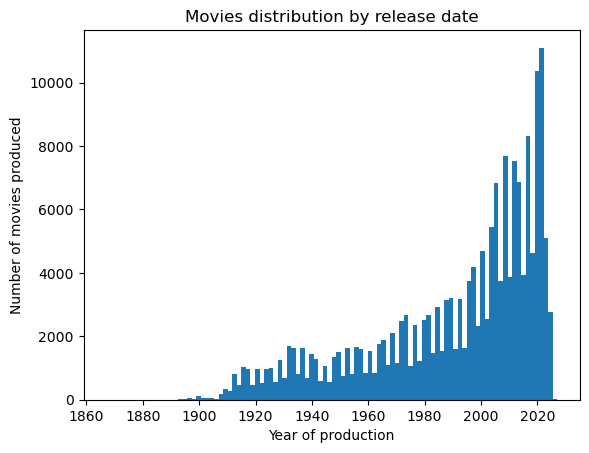

In [8]:
plt.figure()
plt.title('Movies distribution by release date')
plt.hist(df_movies_tmdb['release_date'], bins= 100)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.show()


Number of movies by popularity

0 is the most used value, but it's not meaningful for the analysis because 0 means "no value"

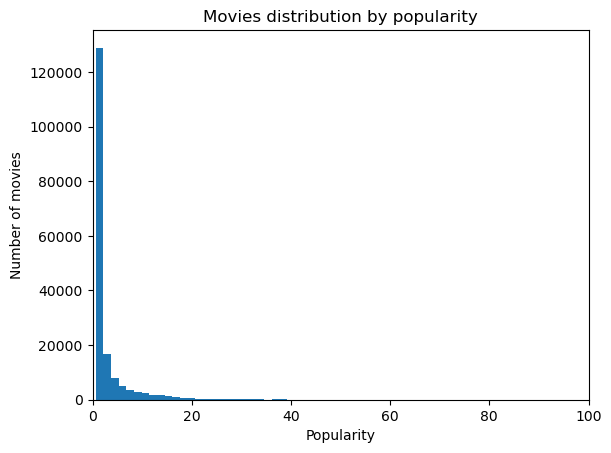

In [9]:
df_movies_tmdb_1 = df_movies_tmdb[df_movies_tmdb['popularity'] != 0]

plt.figure()
plt.title('Movies distribution by popularity')
plt.hist(df_movies_tmdb_1['popularity'], bins= 1000)
plt.xlabel('Popularity')
plt.ylabel('Number of movies')
plt.xlim([0,100])
plt.show()

Grouping by genres

In [10]:
# from now on, if df == df_movies_tmdb, the datset taken into account is df_movies_tmdb
# grouping by genres (need a smaller dataframe to work with)
df_reduced = df_movies_tmdb[['title', 'genres', 'release_date']]

In [11]:
# since there is more than 1 genre for each movie, we have to select all of them
df_grouped_genres = df_reduced.explode('genres')

# groupby genres
df_grouped_genres = df_grouped_genres.groupby('genres')

print("The number of different genres is:")
print(len(df_grouped_genres['genres'].unique()))
print('\n')

# print the groups
print('Print the groups')
for genre, group in df_grouped_genres:
    print(f"Genre: {genre}")
    print(group)

The number of different genres is:
359


Print the groups
Genre: Absurdism
                                             title     genres  release_date
2641                                  Brain Donors  Absurdism          1992
5025                                     Airplane!  Absurdism          1980
5938                           The Golf Specialist  Absurdism          1930
6925                              The Flower Thief  Absurdism          1962
8720               Monty Python and the Holy Grail  Absurdism          1975
...                                            ...        ...           ...
180218          Without a Paddle: Nature's Calling  Absurdism          2009
187443                      Take the Money and Run  Absurdism          1969
189000                   The L.A. Riot Spectacular  Absurdism          2005
191924  Trailer Park Boys: Countdown to Liquor Day  Absurdism          2009
197954                                 Top Secret!  Absurdism          1984

[120 rows x 

In [12]:
title = df_movies.title
df_movies.index = title
df_movies.index.is_unique


False

In [13]:
a = df_movies['title'].unique()
len(a)

69247

Select n most relevant genres, ordering them by recurrence

In [14]:
# counting how many movies share the same genre
counts = df_reduced.explode('genres')['genres'].value_counts()

print('Number of movies for each genre:')
print(counts)
print('\n')

# choosing the most relevant genres
n_relevant_genres = 50
relevant_genres = counts[:n_relevant_genres]

print('The relevant genres are:')
print(relevant_genres)

# making a list of names of the relevant genres
relevant_genres_names = relevant_genres.index.tolist()

Number of movies for each genre:
genres
Drama                 92790
Comedy                31162
Thriller              29519
Romance Film          27931
Black-and-white       21542
                      ...  
Romantic thriller         1
War effort                1
Breakdance                1
Conspiracy fiction        1
Homoeroticism             1
Name: count, Length: 359, dtype: int64


The relevant genres are:
genres
Drama                     92790
Comedy                    31162
Thriller                  29519
Romance Film              27931
Black-and-white           21542
Action                    19490
World cinema              18806
Crime Fiction             18647
Indie                     18528
Short Film                15792
Horror                    15191
Silent film               12907
Action/Adventure          11160
Adventure                 10746
Romantic drama            10043
Mystery                    9910
Musical                    9166
Family Film                8626
Doc

ANALISYS WITH df_movies

In [15]:
# selecting the right columns and cleaning them
df_movies_reduced = df_movies[['title', 'genres', 'release_date']]
df_grouped = df_movies_reduced.explode('genres')
df_grouped = df_grouped.groupby('genres')

print("The number of different genres is:")
print(len(df_grouped['genres'].unique()))
print('\n')

# print the groups
print('Print the groups')
for genre, group in df_grouped:
    print(f"Genre: {genre}")
    print(group)


The number of different genres is:
363


Print the groups
Genre: Absurdism
                                                                                 title  \
title                                                                                    
Brain Donors                                                              Brain Donors   
Airplane!                                                                    Airplane!   
The Golf Specialist                                                The Golf Specialist   
Monty Python and the Holy Grail                        Monty Python and the Holy Grail   
The Magic Christian                                                The Magic Christian   
...                                                                                ...   
Without a Paddle: Nature's Calling                  Without a Paddle: Nature's Calling   
Take the Money and Run                                          Take the Money and Run   
The L.A. Riot Spectacular

In [16]:
# counting how many movies share the same genre
counts = df_movies_reduced.explode('genres')['genres'].value_counts()

print('Number of movies for each genre:')
print(counts)
print('\n')

# choosing the most relevant genres
n_relevant_genres = 20
relevant_genres = counts[:n_relevant_genres]

print('The relevant genres are:')
print(relevant_genres)

# making a list of names of the relevant genres
relevant_genres_names = relevant_genres.index.tolist()

Number of movies for each genre:
genres
Drama                   32015
Comedy                  15648
Romance Film             9770
Black-and-white          8817
Thriller                 8408
                        ...  
Comdedy                     1
C-Movie                     1
Linguistics                 1
Silhouette animation        1
Homoeroticism               1
Name: count, Length: 363, dtype: int64


The relevant genres are:
genres
Drama               32015
Comedy              15648
Romance Film         9770
Black-and-white      8817
Thriller             8408
Action               8275
Short Film           7208
World cinema         7155
Indie                6779
Crime Fiction        6625
Silent film          5056
Documentary          4998
Horror               4982
Adventure            4732
Action/Adventure     4557
Family Film          4165
Musical              3984
Comedy film          3717
Romantic drama       3345
Mystery              3056
Name: count, dtype: int64


Number of movies produced every year, grouped by genres

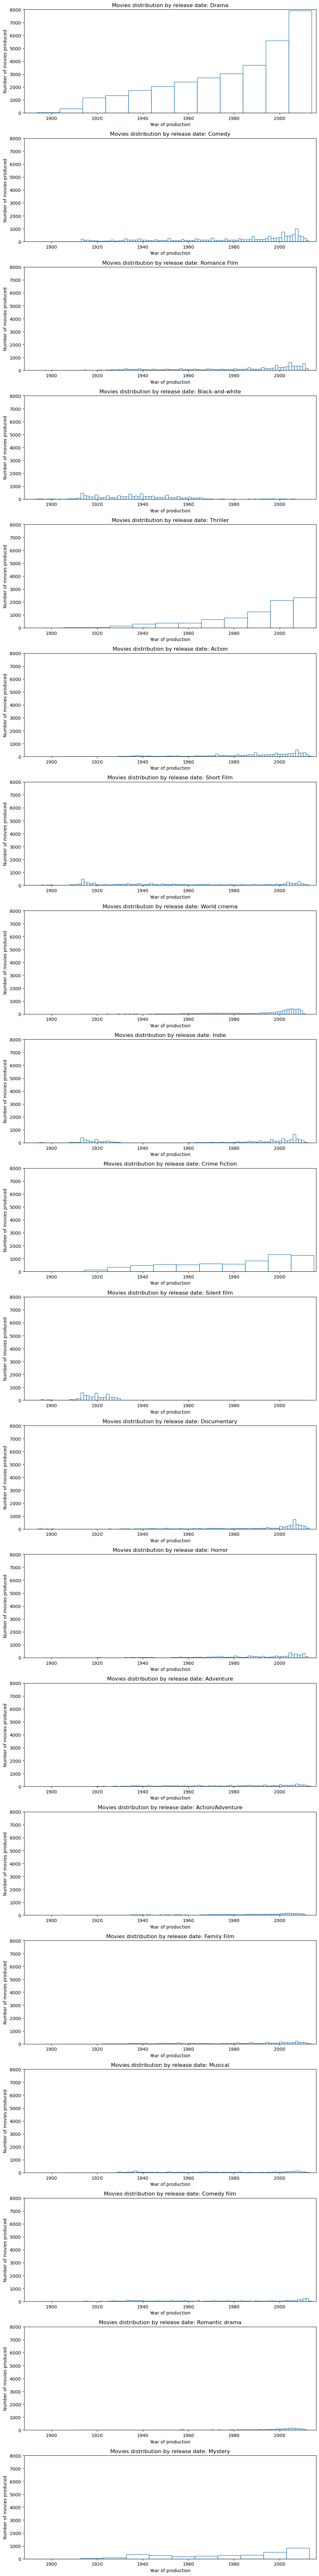

In [17]:
# since the histograms are weird, I choose to drop every row that has missing values but it didn't solve the problem
# df_completeReleaseDate =  df_movies.dropna(subset=['release_date'])

# adjustable plot, depending on the number of relevant genres
n = len(relevant_genres_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016
y_min = 0
y_max = 8000

for i, genre in enumerate(relevant_genres_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {genre}')
    
    # genres filtering
    genre_movies = df_movies[df_movies['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(genre_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)



plt.tight_layout() 
plt.show()


Same plot as before, but now the yaxis limit is not set: differences inside each graph can be better seen, while comparison between genres may be more difficult

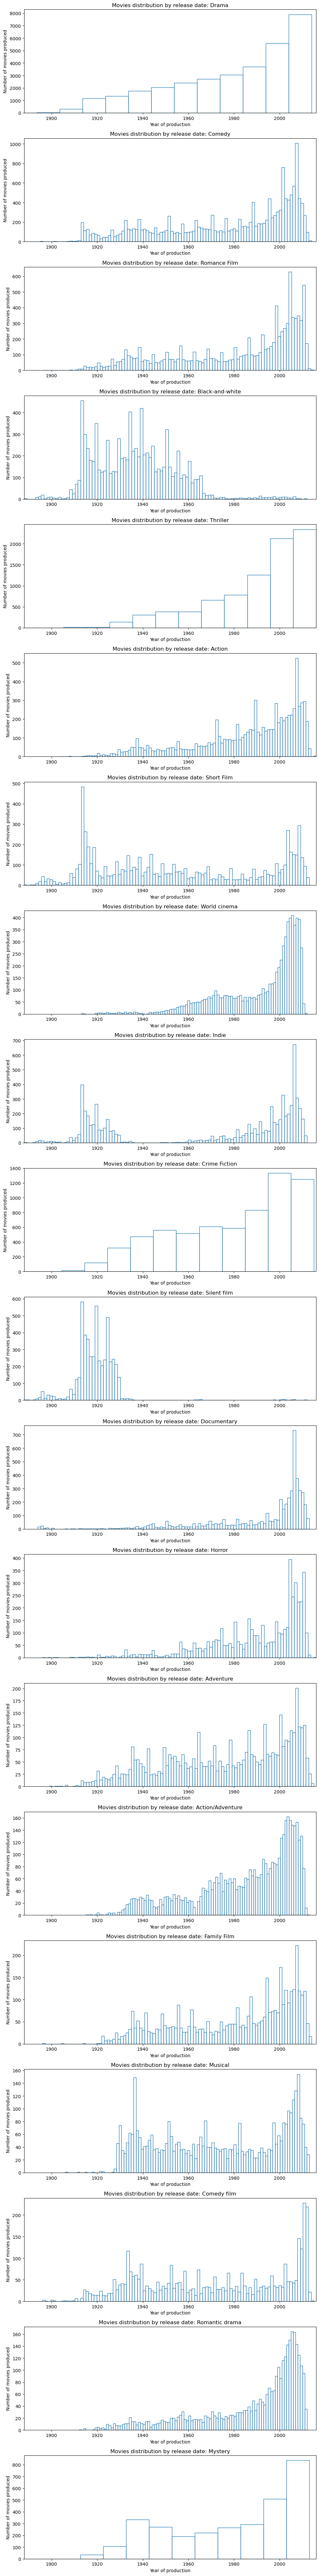

In [18]:
# adjustable plot, depending on the number of relevant genres
n = len(relevant_genres_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, genre in enumerate(relevant_genres_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {genre}')
    
    # genres filtering
    genre_movies = df_movies[df_movies['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(genre_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()

Vote average over date of production of the movie (keep in mind that the voting does not take place in the same year of production, but from then on)

Popularity over date of production of the movie (keep in mind that the popularity does not take place in the same year of production, but from then on) 

From the TMDb documentation: "Popularity is a fairly important metric here on TMDB. It helps us boost search results, adds an incredibly useful sort value for discover, and is also just kind of fun to see items chart up and down. You can think of popularity as being a "lifetime" popularity score that is impacted by the attributes below. It's calculated quite differently than trending."

Number of movies produced in each region (Production Country)

In [19]:
# only a few columns are needed
df_country_reduced = df_movies[['title', 'genres', 'release_date', 'countries']]

In [20]:

# counting how many movies share the same country
country_counts = df_country_reduced.explode('countries')['countries'].value_counts()

print('Number of movies for each country:')
print(country_counts)
print('\n')

# choosing the most relevant genres
n_relevant_countries = 20
relevant_countries = country_counts[:n_relevant_countries]

print('The relevant countries are:')
print(relevant_countries)

# making a list of names of the relevant genres
relevant_countries_names = relevant_countries.index.tolist()

Number of movies for each country:
countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: count, Length: 146, dtype: int64


The relevant countries are:
countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
Japan                        2405
Canada                       2372
Germany                      2306
Argentina                    1418
Hong Kong                    1115
Spain                        1045
Australia                    1038
South Korea                   861
Mexico                        844
Netherlands               

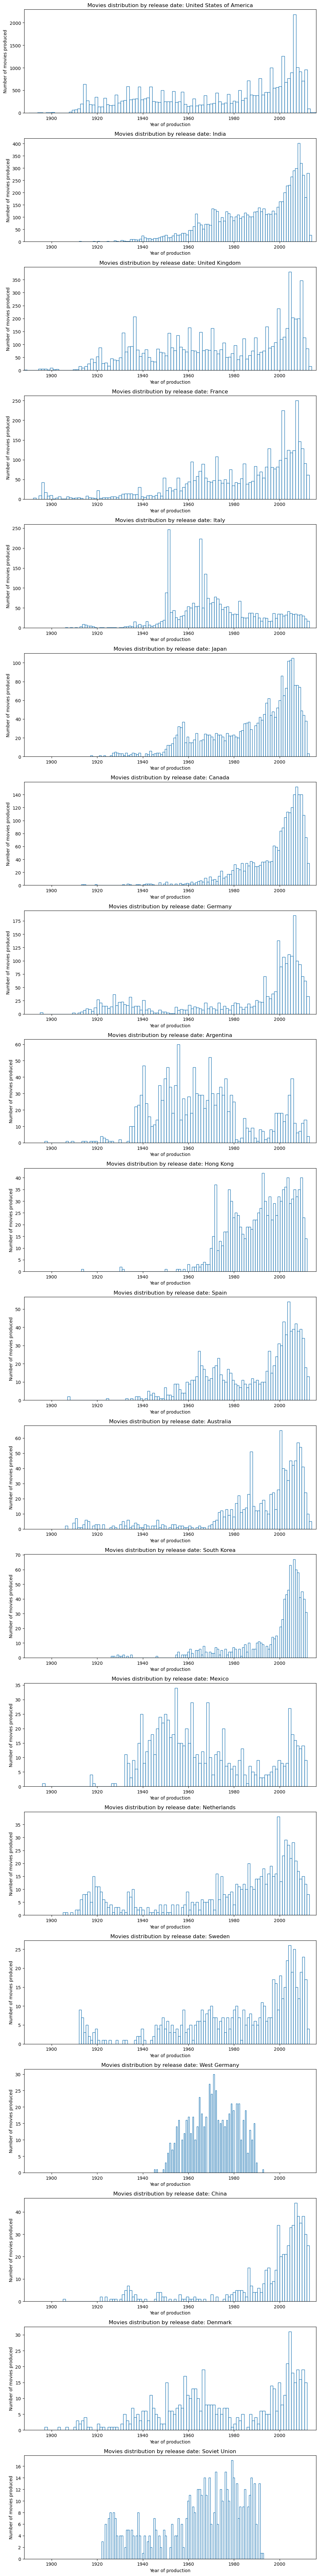

In [21]:
# adjustable plot, depending on the number of relevant genres
n = len(relevant_countries_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, country in enumerate(relevant_countries_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {country}')
    
    # country filtering
    country_movies = df_country_reduced[df_country_reduced['countries'].apply(lambda x: x is not None and country in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(country_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()

In [22]:
# continents division
northAmerica = ['United States of America ', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti']
europe = ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia' 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR']
asia = ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories']
australia = ['Australia', 'New Zealand']
southAmerica = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba']
africa = ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']

In [23]:
continents = {
    'North America': ['United States of America', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti'],
    'Europe': ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia', 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR'],
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba'],
    'Asia': ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories'],
    'Australia': ['Australia', 'New Zealand'],
    'Africa': ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']
}

# dictionary to map each country to a continent
country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

# drop the rows with no country
df_completeCountry = df_movies.dropna(subset=['countries'])

# extract country names from the lists
df_completeCountry['countries'] = df_completeCountry['countries'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

# add the column 'continent'
df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)



C:\Users\chiar\AppData\Local\Temp\ipykernel_29972\3499453944.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['countries'] = df_completeCountry['countries'].apply(
C:\Users\chiar\AppData\Local\Temp\ipykernel_29972\3499453944.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)


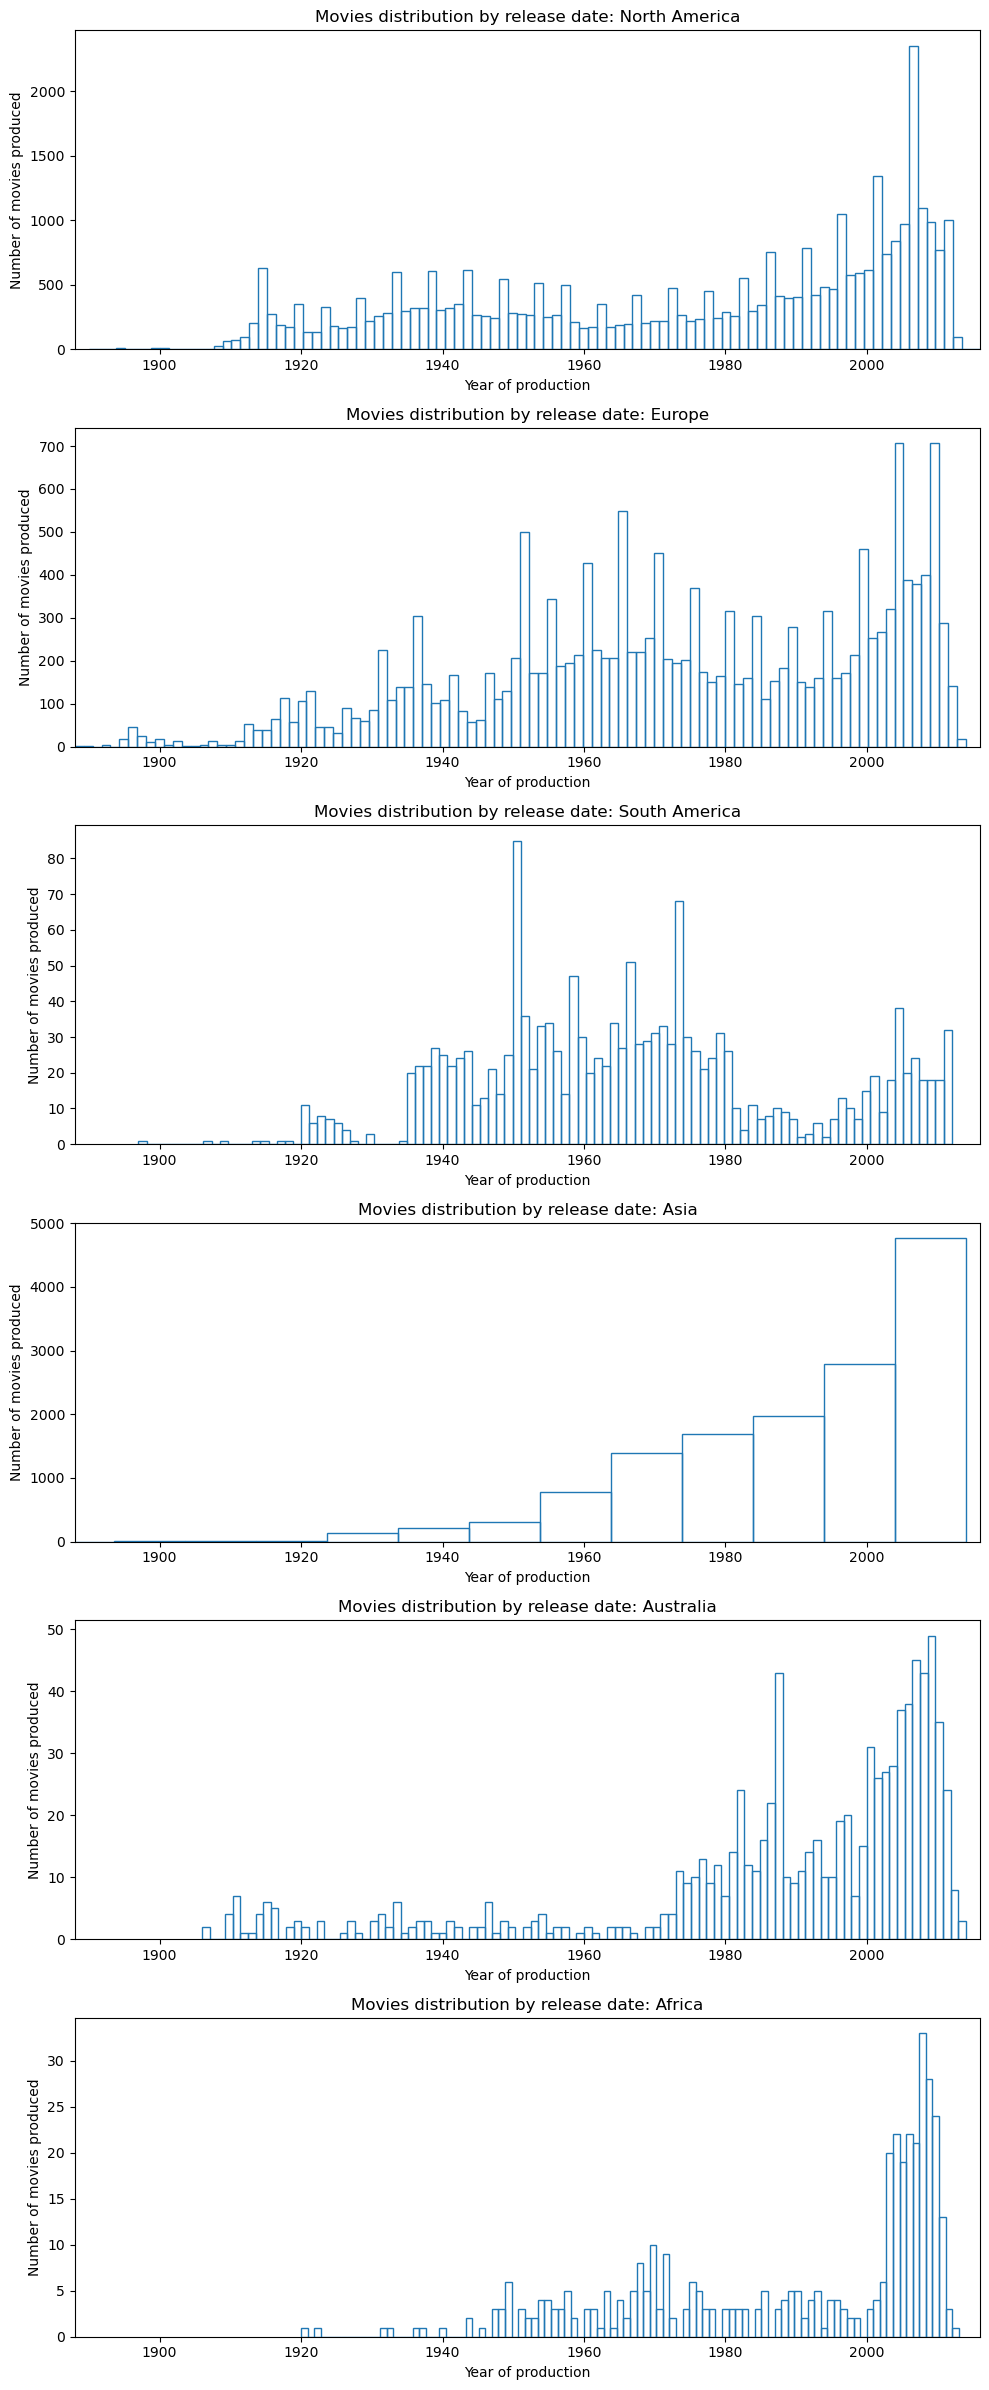

In [26]:
# more cleaning in case no continent is detected
df_completeContinent = df_completeCountry.dropna(subset = ['continent'])


n = 6 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, continent in enumerate(['North America', 'Europe', 'South America', 'Asia', 'Australia', 'Africa']):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {continent}')
    
    # continent filtering
    continent_movies = df_completeContinent[df_completeContinent['continent'].apply(lambda x: isinstance(x, str) and x == continent)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(continent_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()